In [ ]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports, setup and parameters
import numpy as np
import math
import zipfile
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
import tensorflow as tf
from tensorflow.keras import layers


print("TensorFlow version:", tf.__version__)

tf.keras.backend.clear_session()

## CNN parameters

file_path = "/content/drive/MyDrive/University/L3_Project/HAR/data_processing/uci_data"

segment_size = 128
num_input_channels = 6

num_training_iterations = 200
batch_size = 200

l2_reg = 5e-4
learning_rate = 5e-4
dropout_rate = 0.05

n_filters = 8
filters_size = 3
n_hidden = 1024
n_classes = 6
id = 8; # Used to uniquely identify model

# Generate name of ZIP file
name_fzip = "rb"+str(id)+"_"+str(n_filters)+"_"+str(filters_size)+"_"+str(n_hidden)+".zip"

TensorFlow version: 2.15.0


In [ ]:
## Loading the dataset

print('Loading UCI dataset...')

# Reading training data

# Modified paths for Drive
fa = open(f"{file_path}/all_data.csv")
data_train = np.loadtxt(fname = fa, delimiter = ',')
fa.close()

# Reading validation data

fa = open(f"{file_path}/all_data_val.csv")
data_val = np.loadtxt(fname = fa, delimiter = ',')
fa.close()

# Reading test data

fa = open(f"{file_path}/all_data_test.csv")
data_test = np.loadtxt(fname = fa, delimiter = ',')
fa.close()

# Reading labels
#   Training labels
fa = open(f"{file_path}/answers.csv")
labels_train = np.loadtxt(fname = fa, delimiter = ',')
fa.close()

#   Validation labels
fa = open(f"{file_path}/answers_val.csv")
labels_val = np.loadtxt(fname = fa, delimiter = ',')
fa.close()

#   Test labels
fa = open(f"{file_path}/answers_test.csv")
labels_test = np.loadtxt(fname = fa, delimiter = ',')
fa.close()

train_size = data_train.shape[0]
val_size = data_val.shape[0]
test_size = data_test.shape[0]

data_val = np.reshape(data_val, [data_val.shape[0], segment_size * num_input_channels])
labels_val = np.reshape(labels_val, [labels_val.shape[0], n_classes])
labels_val_max = np.expand_dims(np.argmax(labels_val,axis=1),axis=1)

data_test = np.reshape(data_test, [data_test.shape[0], segment_size * num_input_channels])
labels_test = np.reshape(labels_test, [labels_test.shape[0], n_classes])
labels_test_max = np.expand_dims(np.argmax(labels_test,axis=1),axis=1)


print("Dataset was uploaded\n")

Loading UCI dataset...
Dataset was uploaded



In [ ]:
# Create file with data segments and corresponding features for transmission to Nano
data_combined = np.concatenate((data_test,labels_test_max),axis=1)

# Specifying the file path
file_path = 'data_combined.csv'

# Writing the array to the CSV file
np.savetxt(file_path, data_combined, delimiter=',', fmt='%3.4g')

with zipfile.ZipFile(name_fzip,'a') as myzip:
  myzip.write(file_path)

print("Nano transmission file generated")

Nano transmission file generated


Creating CNN architecture

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 128, 6)]       0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128, 8)         152       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 32, 8)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                  

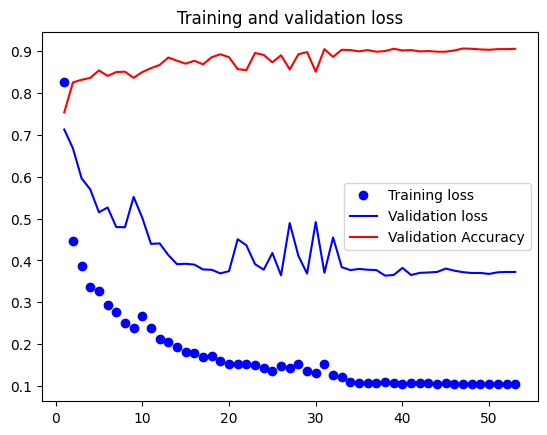

53/53 - 0s - loss: 0.2353 - accuracy: 0.9327 - sparse_categorical_crossentropy: 0.1972 - 488ms/epoch - 9ms/step
Best model, accuracy: 93.27%


In [ ]:
## Create CNN

print("Creating CNN architecture\n")

# Convolutional and pooling layers

input = tf.keras.Input(shape=(1, segment_size, num_input_channels),dtype=np.float32)
l_conv = tf.keras.layers.Conv1D(n_filters,filters_size,strides=1,padding='SAME',use_bias=True,activation='relu')(input)
l_pool = tf.keras.layers.MaxPooling2D(pool_size=[1,4],strides=[1,4],padding='SAME')(l_conv)

# Flattening layers
l_flat = tf.keras.layers.Flatten()(l_pool)

# Fully connected layer with dropout and regularizer
l_dropout = tf.keras.layers.Dropout(dropout_rate)(l_flat) # Adjustable dropout?
reg = tf.keras.regularizers.L2(l2=l2_reg)
l_dense = tf.keras.layers.Dense(n_hidden,activation='relu',use_bias=True,kernel_regularizer=reg)(l_dropout)

# Prediction/Softmax layer
l_predictions = tf.keras.layers.Dense(n_classes,activation='softmax')(l_dense)

# Format data for training
data_train_reformatted = np.reshape(data_train,newshape=(-1,1,128,6))
data_val_reformatted = np.reshape(data_val,newshape=(-1,1,128,6))
data_test_reformatted = np.reshape(data_test,newshape=(-1,1,128,6))

labels_test_squeezed = np.argmax(labels_test,axis=1)
labels_train_squeezed = np.argmax(labels_train,axis=1)
labels_val_squeezed = np.argmax(labels_val,axis=1)

# Compile model
train_model = tf.keras.Model(inputs=input, outputs=l_predictions)
train_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy','sparse_categorical_crossentropy'])
train_model.summary()

# Define training callbacks
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint("har_best.keras", monitor="val_loss", save_best_only=True)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')


# Train model
history = train_model.fit(
    x=data_train_reformatted,
    y=labels_train_squeezed,
    batch_size=batch_size,
    epochs=num_training_iterations,
    verbose=1,
    validation_data=(data_val_reformatted,labels_val_squeezed),
    validation_freq=1,
    callbacks=[checkpoint,earlyStopping,reduce_lr_loss]
)

# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs,val_accuracy,'r', label='Validation Accuracy')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Load best model and check performance
model = tf.keras.models.load_model('har_best.keras')
metrics = model.evaluate(x=data_test_reformatted, y=labels_test_squeezed, verbose=2)
acc = metrics[1]
print('Best model, accuracy: {:5.2f}%'.format(100 * acc))


In [ ]:
# Generate representative dataset required for integer quantisation
def representative_data_gen():
  # random_indices = np.random.randint(0,data_train_reformatted.shape[0],size=500)
  for i in range(200):
    input_data1 = input_data = np.float32(np.expand_dims(data_train_reformatted[i],axis=0))
    yield [input_data1]

In [ ]:
# Convert keras model to unquantised (float16) tflite file for comparison
tflite_model_name = 'har_fp16'  # Will be given .tflite suffix
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_fp16 = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model_fp16)
with zipfile.ZipFile(name_fzip,'a') as myzip:
  myzip.write(tflite_model_name+'.tflite')

INFO:tensorflow:Assets written to: /tmp/tmpsz_685le/assets


In [ ]:
# Convert Keras model to a quantised tflite model
tflite_model_name = 'har_model_ui8'  # Will be given .tflite suffix
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_ui8 = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model_ui8)
with zipfile.ZipFile(name_fzip,'a') as myzip:
  myzip.write(tflite_model_name+'.tflite')

# Check model input/output types
interpreter = tf.lite.Interpreter(model_content=tflite_model_ui8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)
print(interpreter.get_input_details())

INFO:tensorflow:Assets written to: /tmp/tmpuqfjicm_/assets
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>
[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1,   1, 128,   6], dtype=int32), 'shape_signature': array([ -1,   1, 128,   6], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.026062745600938797, 135), 'quantization_parameters': {'scales': array([0.02606275], dtype=float32), 'zero_points': array([135], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [ ]:
# Save models as files
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"har_model_fp16.tflite"
tflite_model_file.write_bytes(tflite_model_fp16)

# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"har_model_ui8.tflite"
tflite_model_quant_file.write_bytes(tflite_model_ui8)

279600

In [ ]:
# Define necessary variables for evaluation functions
test_data_index = 1
test_segments = np.float32(data_test_reformatted)
test_labels = labels_test_squeezed

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_data_indices):
  global test_segments
  global test_feature_data

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_data_indices),), dtype=int)
  for i, test_data_index in enumerate(test_data_indices):
    test_image = test_segments[test_data_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [ ]:
# Helper function to evaluate a TFLite model on all test data
def evaluate_model(tflite_file, model_type):
  global test_segments
  global test_labels

  test_data_indices = range(test_segments.shape[0])
  predictions = run_tflite_model(tflite_file, test_data_indices)

  counter = 0
  for i in range(len(test_segments)):
    if test_labels[i] == predictions[i]:
      counter += 1

  accuracy = counter * 100 / len(test_segments)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_segments)))

In [ ]:
# Evaluate model accuracy
samples_idx = np.random.randint(0,test_segments.shape[0],30)
evaluate_model(tflite_model_quant_file, model_type="Quantized")
evaluate_model(tflite_model_file, model_type="Float")

Quantized model accuracy is 92.4484% (Number of test samples=1695)
Float model accuracy is 93.1563% (Number of test samples=1695)


In [ ]:
# Save one segment of quantised test data as c array for testing
input1_details = interpreter.get_input_details()[0]
input1_scale, input1_zero_point = input1_details["quantization"]

test_array_data = np.floor(test_segments[0][0] / input1_scale + input1_zero_point).astype(int)

data_filename = 'test_data'
c_str = ''
c_str += '#include "' + data_filename + '.h"\n\n'
c_str += 'uint8_t test_input1[] = {\n'

# Add values of single test data segment
for i,element in enumerate(test_array_data.flat):
  if element < 0:
    element = 0
  elif element > 255:
    element = 255
  c_str += str(element)
  if (i + 1) < len(test_array_data.flat):
      c_str += ','
  if (i + 1) % 12 == 0:
      c_str += '\n '


c_str += '};\n'
c_str += 'const unsigned int test_input1_len = ' + str(len(test_segments[0][0].flatten()))
c_str += ';\n\n'

c_str += '// test_label = ' + str(labels_test_squeezed[0]) + ';\n'

with open(data_filename + '.cpp', 'w') as file:
  file.write(c_str)
with zipfile.ZipFile(name_fzip,'a') as myzip:
  myzip.write(data_filename+'.cpp')

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data):
  var_name = 'g_model'

  c_str = ''

  # Create header guard
  c_str += '#include "har_detection_model.h"\n\n'


  # Declare C variable
  c_str += 'const unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Add array length at top of file
  c_str += 'const unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  return c_str

In [ ]:
# # Write TFLite model to a C source file
c_model_name = 'har_detection_model'
with open(c_model_name + '.cpp', 'w') as file:
  file.write(hex_to_c_array(tflite_model_ui8))
with zipfile.ZipFile(name_fzip,'a') as myzip:
  myzip.write(c_model_name+'.cpp')

# Alternative method
# !xxd -i har_model.tflite > har_detection_model.cpp